# Dataset : News Headlines Dataset For Sarcasm Detection

### import library yang dibutuhkan 


In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM,Bidirectional,GRU
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


Impor data yang sudah di download

In [2]:
data = pd.read_json('news-headlines-dataset-for-sarcasm-detection\Sarcasm_Headlines_Dataset_v2.json', lines=True) #import data json for each line

### Data Understanding

Berikut adalah keterangan data yang di download :
- is_sarcastic  : apakah kalimat terebut mengandung sarkasme
- headline      : kalimat pada suatu artikel
- article_link  : link pada artikel tersebut

In [3]:
data

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...


membuat plot untuk mengetahui data sarcastic yang dibuat

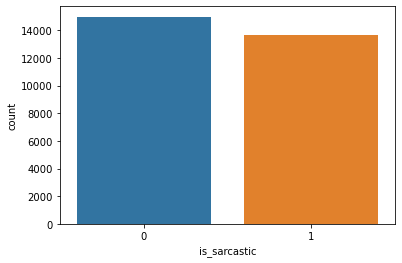

In [4]:

sns.countplot(data['is_sarcastic'])

## Preprocessing

mengimport library yang dibutuhkan  

In [5]:
import string
import nltk
import re
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\Alvin
[nltk_data]     Buana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Agar model dapat menerima data yang diberikan maka harus dilakukan pre-processing. Berikut adalah pre-processing yang dibuat dalam cell dibawah ini :
- menghapus tanda baca
- membuat semua text menjadi huruf kecil
- menghapus baris baru
- menghapus tab pada kalimat
- menghapus space yang lebih
- mengurangi text yang kurang bermakna
- mengnormalisasi teks/kata dengan berdasarkan pada bentuk dasar yang merupakan bentuk lemma-nya

In [6]:
data['clean_headline'] = data['headline'].apply(lambda x: ''.join([c for c in x if c not in string.punctuation]))
data['clean_headline']=data['clean_headline'].apply(lambda x: x.lower())
data['clean_headline'] = data['clean_headline'].apply(lambda x: x.replace('\n', ' '))
data['clean_headline'] = data['clean_headline'].apply(lambda x: x.replace('\t', ' '))
data['clean_headline'] = data['clean_headline'].apply(lambda x: re.sub(' +',' ',x))
data['clean_headline'] = data['clean_headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
data['clean_headline'] = data['clean_headline'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))

### Data Preparation

Data yang sudah dibersihkan harus dibagi menjadi dua, yaitu train data dan test data. Hal ini digunakan untuk melatih dan mengetes model yang sudah dibuat agar mendapat akurasi yang tepat dan model dapat digunakan pada dataset yang kurang dikenal.

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(data['clean_headline'],data['is_sarcastic'],test_size=0.3,random_state=100)

Setelah dipisah antara train data dan text data, kedua data harus diubah menjadi angka agar diterima oleh model. Tokenizer pada cell dibawah digunakan  untuk membagi teks yang dapat berupa kalimat, paragraf atau dokumen, menjadi token-token/bagian-bagian tertentu. Hasil dari Tokenizer adalah berupa sequences yang berisi angka. Pad_sequences pada cell dibawah digunakan untuk menyamakan sequences dari hasil tokenizer karena hasil sequences pada tokenizer memiliki size yang berbeda - beda. Oleh karena itu size pada sequences harus diatur agar dapat diterima oleh model.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
token = Tokenizer(num_words =500,oov_token='<OOV>')
token.fit_on_texts(x_train)
training_sequences = token.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,maxlen=100,padding='post',truncating='post')

testing_sequences = token.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,maxlen=100,padding='post',truncating='post')


In [11]:
import numpy as np
train_data = np.array(training_padded)
train_labels = np.asarray(y_train)
test_data = np.array(testing_padded)
test_labels = np.asarray(y_test)

In [13]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0']


## Deep Learning Approach

## Using Bidirectional LSTM

Setelah data melalui proses data preparation, data diubah menjadi array agar dapat diterima juga oleh model.

Setelah data sudah dibuat menjadi array, model neural network siap dibuatkan. Dari sini, model dibuat dengan embedding layer dan bidirectional LSTM layer. Agar lebih jelas, Embedding layer digunakan untuk mengencode kembali data yang sudah diberikan. Kemudian bidirectional LSTM merupakan model LSTM yang bergerak secara duah arah sehingga model yang dilalui tentu bisa diproses dengan dua arah.

![LSTM](https://d1zx6djv3kb1v7.cloudfront.net/wp-content/media/2019/05/Deep-Dive-into-Bidirectional-LSTM-i2tutorials.jpg "Bidirectional LSTM")

In [16]:
model = Sequential()
model.add(Embedding(500,100,input_length=100)) # data diencode kembali dalam proses ini.
model.add(Bidirectional(LSTM(units=32, recurrent_dropout = 0.2 , dropout = 0.2, return_sequences=True))) 
model.add(Bidirectional(LSTM(units=8, recurrent_dropout = 0.2 , dropout = 0.2)))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_data,train_labels,epochs=20,validation_data=(test_data,test_labels),callbacks=[EarlyStopping(monitor='val_loss', restore_best_weights=True,patience=5)])

C:\Python3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 20033 samples, validate on 8586 samples
Epoch 1/20
20033/20033 [==============================] - 64s 3ms/step - loss: 0.5832 - accuracy: 0.6822 - val_loss: 0.5311 - val_accuracy: 0.7253
Epoch 2/20
20033/20033 [==============================] - 62s 3ms/step - loss: 0.5196 - accuracy: 0.7298 - val_loss: 0.5194 - val_accuracy: 0.7312
Epoch 3/20
20033/20033 [==============================] - 61s 3ms/step - loss: 0.5012 - accuracy: 0.7385 - val_loss: 0.5209 - val_accuracy: 0.7289
Epoch 4/20
20033/20033 [==============================] - 57s 3ms/step - loss: 0.4912 - accuracy: 0.7425 - val_loss: 0.5120 - val_accuracy: 0.7314
Epoch 5/20
20033/20033 [==============================] - 59s 3ms/step - loss: 0.4834 - accuracy: 0.7461 - val_loss: 0.5158 - val_accuracy: 0.7335
Epoch 6/20
20033/20033 [==============================] - 61s 3ms/step - loss: 0.4742 - accuracy: 0.7528 - val_loss: 0.5095 - val_accuracy: 0.7328
Epoch 7/20
20033/20033 [==============================] - 62s 3ms/ste

### Model Evaluation

Model yang sudah dibuat akan dievaluasikan. untuk dataset ini, *confusion matrix* lebih bisa diandalkan sebagai metrik dikarenakan kita bisa melihat seberapa banyak error yang terjadi saat melakukan prediksi pada data tes.

In [43]:

pred = model.predict(test_data)
con_mat = confusion_matrix(test_labels,pred.round())
con_mat

array([[3897,  640],
       [1660, 2389]], dtype=int64)

*Confusion Matrix* adalah sebuah metrik dari scikit-learn yang digunakan untuk membandingkan nilai aktual dengan nilai prediksi. Metrik ini lebih sering digunakan untuk masalah klasifikasi. Hasil dari confusion matrix adalah mengeluarkan sebuah tabel yang akan menunjukan total error yang didapat oleh model.

![Confusion Matrix](https://www.interhit.org/wp-content/uploads/2021/02/Cara-mengevaluasi-model-Anda-menggunakan-Confusion-Matrix.png)

Berikut adalah penjelasan dari setiap isi dari tabel tersebut :
- ***True Posisitve(TP)***  : Terjadi apabila hasil prediksi bernilai positif (1) dan sesuai dengan data yang sebenarnya (1)
- ***False Posisitve(FP)*** : Terjadi apabila hasil prediksi bernilai positif (1) tetapi tidak sesuai dengan data yang sebenarnya (0)
- ***True Negative(TN)***   : Terjadi apabila hasil prediksi bernilai negatif (0) dan sesuai dengan data yang sebenarnya (0)
- ***False Negative(FN)***  : Terjadi apabila hasil prediksi bernilai negatif (0) tetapi tidak sesuai dengan data yang sebenarnya (1)


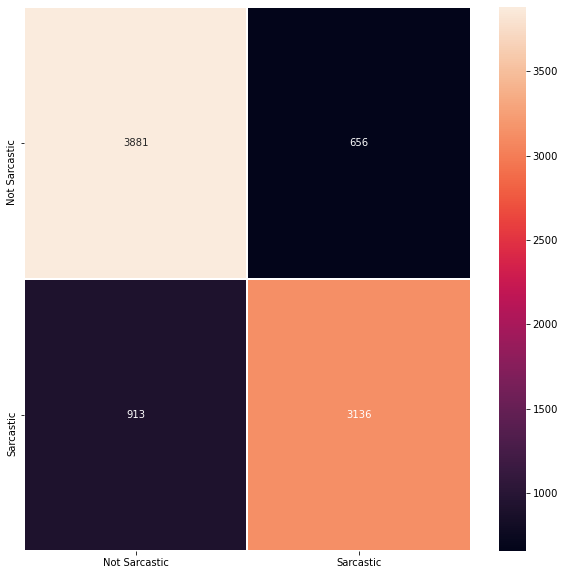

In [14]:
cm = pd.DataFrame(con_mat , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(con_mat , linewidth = 1 , annot = True, fmt='d' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

## Using GRU

GRU adalah gated recurrent unit yang merupakan bagian dari recurrent neural network. GRU layer mirip dengan LSTM tetapi lebih ringan untuk sisi strukturnya karena gate yang digunakan oleh GRU layer hanya 2 gate yaitu update dan reset. Berikut adalah penjelasan setiap gate :
- Update Gate : mengambil bagian yang perlu diingat
- Forget Gate : melupakan bagian yang tidak perlu

![GRU](https://www.researchgate.net/profile/Yizhou-Yu-2/publication/301648210/figure/fig2/AS:667816889962500@1536231362452/The-internal-structure-of-a-gate-recurrent-unit-GRU.png "GRU")

In [23]:
model = Sequential()
model.add(Embedding(500,100,input_length=100)) 
model.add(Bidirectional(GRU(units=128, recurrent_dropout = 0.2 , dropout = 0.2,return_sequences=True)))
model.add(Bidirectional(GRU(units=64, recurrent_dropout = 0.2 , dropout = 0.2)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_data,train_labels,epochs=20,validation_data=(test_data,test_labels),callbacks=[EarlyStopping(monitor='val_loss', restore_best_weights=True,patience=5)])

C:\Python3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 20033 samples, validate on 8586 samples
Epoch 1/20
20033/20033 [==============================] - 219s 11ms/step - loss: 17538.0753 - accuracy: 0.6821 - val_loss: 0.5620 - val_accuracy: 0.7025
Epoch 2/20
20033/20033 [==============================] - 227s 11ms/step - loss: 0.5357 - accuracy: 0.7109 - val_loss: 0.5499 - val_accuracy: 0.7035
Epoch 3/20
20033/20033 [==============================] - 222s 11ms/step - loss: 0.5265 - accuracy: 0.7194 - val_loss: 0.5463 - val_accuracy: 0.7063
Epoch 4/20
20033/20033 [==============================] - 221s 11ms/step - loss: 0.5209 - accuracy: 0.7222 - val_loss: 0.5440 - val_accuracy: 0.7063
Epoch 5/20
20033/20033 [==============================] - 221s 11ms/step - loss: 0.5171 - accuracy: 0.7248 - val_loss: 0.5410 - val_accuracy: 0.7114
Epoch 6/20
20033/20033 [==============================] - 218s 11ms/step - loss: 0.5121 - accuracy: 0.7301 - val_loss: 0.5406 - val_accuracy: 0.7113
Epoch 7/20
20033/20033 [=============================

## Prediction

Setelah melakukan evaluasi dan menemukan bahwa hasil evaluasi baik maka model siap untuk digunakan untuk prediksi. Berikut kita mengambil sample secara acak pada dataset lalu diprediksi oleh model.

In [164]:
headline_test = data.headline.sample()
result_test = data.is_sarcastic[data.headline == headline_test.iloc[0]].iloc[0]
pred_sequences = token.texts_to_sequences(headline_test)
pred_padded = pad_sequences(pred_sequences,maxlen=100,padding='post',truncating='post')
pred_padded = np.array(pred_padded)
pred_result = model.predict(pred_padded)
pred_result = pred_result[0][0].round().astype(int)
print("News              : "+headline_test.iloc[0])
print("True Value        : "+("yes" if result_test == 1 else "no"))
print("Predicted Value   : "+("yes" if pred_result == 1 else "no"))

News              : academy to give runners-up detailed progress reports outlining where stars can improve
True Value        : yes
Predicted Value   : yes
